In [270]:
import os
import time
import pandas as pd
import numpy as np
import numpy.random as npr
import copy
import re
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm
from scipy.special import digamma, loggamma
from scipy.sparse import csr_matrix
from typing import List, Dict, Tuple, Set, Optional

In [269]:
def log_sum_exp(vec):
    vec_max = np.max(vec, axis=0)
    exp_vec = np.exp(vec - vec_max)
    sum_exp_vec = np.sum(exp_vec)
    log_sum_exp = np.log(sum_exp_vec) + vec_max
    return log_sum_exp

def init_variational_params(documents, K):
    N, V = documents.shape
    LAMBDA = np.random.uniform(low=0.01, high=1.0, size=(K, V))
    GAMMA = np.ones((N, K))
    PHI = []
    for document in documents:
        M = np.sum((document > 0).astype("int32"))
        document_PHI = np.ones((M, K))
        document_PHI = document_PHI / K
        PHI.append(document_PHI)
        
    return LAMBDA, GAMMA, PHI

def compute_ELBO(LAMBDA, GAMMA, PHI, documents, nonzero_idxs, K):
    ELBO = 0
    N, _ = documents.shape

    E_log_p_BETA = np.sum((ETA-1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True))))
    ELBO += E_log_p_BETA

    E_log_p_THETA = np.sum((ALPHA-1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True))))
    ELBO += E_log_p_THETA

    E_log_p_x_z = 0
    for i in range(N):
        document = documents[i]
        nonzero_idx = nonzero_idxs[i]
        word_idx = 0
        for idx in nonzero_idx:
            E_log_p_x_z += document[idx] * np.sum(PHI[i][word_idx] * (digamma(GAMMA[i])-digamma(np.sum(GAMMA[i])))) \
                + document[idx] * np.sum(PHI[i][word_idx] * (digamma(LAMBDA[:, idx])-digamma(np.sum(LAMBDA, axis=1))))
            word_idx += 1
    ELBO += E_log_p_x_z

    E_log_q_BETA = np.sum(-loggamma(np.sum(LAMBDA, axis=1)) + np.sum(loggamma(LAMBDA), axis=1) \
        - np.sum((LAMBDA - 1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True))), axis=1))
    ELBO += E_log_q_BETA

    E_log_q_THETA = np.sum(-loggamma(np.sum(GAMMA, axis=1)) + np.sum(loggamma(GAMMA), axis=1) \
        - np.sum((GAMMA - 1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True))), axis=1))
    ELBO += E_log_q_THETA

    E_log_q_z = 0
    for i in range(N):
        document = documents[i]
        nonzero_idx = nonzero_idxs[i]
        word_idx = 0
        for idx in nonzero_idx:
            E_log_q_z += -document[idx] * np.sum(PHI[i][word_idx] * np.log(PHI[i][word_idx]))
            word_idx += 1
    ELBO += E_log_q_z

    return ELBO

In [283]:
def simulate_LDA(N, avg_doc_length, K, V, ETA=0.1, ALPHA=0.5, rs_int=np.random.randint(low=0, high=100)):
    rs = npr.RandomState(rs_int) 
    BETA = rs.dirichlet(np.full(V, ETA), size=K)
    THETA = rs.dirichlet(np.full(K, ALPHA), size=N)
    doc_lengths = rs.poisson(avg_doc_length, size=N)
    
    row_idxs = []
    col_idxs = []
    values = []
    nonzero_idxs = []

    for i in range(N):
        doc_word_counts = np.zeros(V)
        for _ in range(doc_lengths[i]):
            z_ij = rs.choice(K, p=THETA[i])
            x_ij = rs.choice(V, p=BETA[z_ij])
            doc_word_counts[x_ij] += 1
        doc_nonzero = np.nonzero(doc_word_counts)[0]
        doc_nonzero = np.array(sorted(doc_nonzero))
        nonzero_idxs.append(doc_nonzero)

        row_idxs.extend([i] * len(doc_nonzero))
        col_idxs.extend(doc_nonzero)
        values.extend(doc_word_counts[doc_nonzero])
    documents = csr_matrix((values, (row_idxs, col_idxs)), shape=(N, V)).toarray()
    
    return documents, nonzero_idxs, BETA, THETA

In [305]:
N = 100
avg_doc_length = 150
K = 5
V = 1000
ALPHA = 1 / K
ETA = 100 / V
documents, nonzero_idxs, BETA, THETA = simulate_LDA(N, avg_doc_length, K, V, ETA, ALPHA)
LAMBDA, GAMMA, PHI = init_variational_params(documents, K=5)

Initial ELBO: -160657.9833535005

Iteration 1


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 101.69it/s]


Current ELBO: -90658.81344355509 | Change in ELBO: 69999.1699099454

Iteration 2


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 96.77it/s]


Current ELBO: -90265.35122595918 | Change in ELBO: 393.46221759590844

Iteration 3


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 102.81it/s]


Current ELBO: -89893.478964505 | Change in ELBO: 371.8722614541766

Iteration 4


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 106.65it/s]


Current ELBO: -89496.3969432891 | Change in ELBO: 397.0820212159015

Iteration 5


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 112.42it/s]


Current ELBO: -89022.59899959387 | Change in ELBO: 473.79794369523006

Iteration 6


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 90.88it/s]


Current ELBO: -88446.45785493121 | Change in ELBO: 576.1411446626589

Iteration 7


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 98.23it/s]


Current ELBO: -87794.66400708957 | Change in ELBO: 651.7938478416472

Iteration 8


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 80.97it/s]


Current ELBO: -87134.45886800847 | Change in ELBO: 660.2051390810957

Iteration 9


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 90.94it/s]


Current ELBO: -86534.21876014456 | Change in ELBO: 600.2401078639086

Iteration 10


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 84.49it/s]


Current ELBO: -86032.9743576119 | Change in ELBO: 501.24440253265493

Iteration 11


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 105.35it/s]


Current ELBO: -85631.5623163836 | Change in ELBO: 401.4120412283082

Iteration 12


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 88.93it/s]


Current ELBO: -85319.33561782332 | Change in ELBO: 312.2266985602764

Iteration 13


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 89.06it/s]


Current ELBO: -85074.48658184032 | Change in ELBO: 244.84903598300298

Iteration 14


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 93.96it/s]


Current ELBO: -84884.42023408346 | Change in ELBO: 190.0663477568596

Iteration 15


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 63.53it/s]


Current ELBO: -84736.38248501474 | Change in ELBO: 148.03774906872422

Iteration 16


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 109.23it/s]


Current ELBO: -84620.55673539227 | Change in ELBO: 115.82574962246872

Iteration 17


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 89.14it/s]


Current ELBO: -84534.99662083619 | Change in ELBO: 85.5601145560795

Iteration 18


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 91.42it/s]


Current ELBO: -84465.81238338386 | Change in ELBO: 69.18423745232576

Iteration 19


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 98.17it/s]


Current ELBO: -84408.59661673328 | Change in ELBO: 57.21576665058092

Iteration 20


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 83.31it/s]


Current ELBO: -84361.4889567015 | Change in ELBO: 47.107660031775595

Iteration 21


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 74.56it/s]


Current ELBO: -84322.85725855692 | Change in ELBO: 38.63169814458524

Iteration 22


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 101.18it/s]


Current ELBO: -84292.28285701053 | Change in ELBO: 30.57440154638607

Iteration 23


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 95.35it/s]


Current ELBO: -84266.33855181726 | Change in ELBO: 25.944305193275795

Iteration 24


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 89.44it/s]


Current ELBO: -84241.99088193483 | Change in ELBO: 24.34766988242336

Iteration 25


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 111.25it/s]


Current ELBO: -84218.23743171016 | Change in ELBO: 23.753450224670814

Iteration 26


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 83.17it/s]


Current ELBO: -84194.69119475133 | Change in ELBO: 23.546236958834925

Iteration 27


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 92.64it/s]


Current ELBO: -84169.31069448544 | Change in ELBO: 25.380500265891897

Iteration 28


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 91.67it/s]


Current ELBO: -84144.2052913808 | Change in ELBO: 25.105403104636935

Iteration 29


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 88.58it/s]


Current ELBO: -84121.44871286955 | Change in ELBO: 22.756578511252883

Iteration 30


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 92.20it/s]


Current ELBO: -84100.87617032984 | Change in ELBO: 20.572542539710412

Iteration 31


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 99.00it/s]


Current ELBO: -84080.17014330186 | Change in ELBO: 20.706027027976234

Iteration 32


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 78.65it/s]


Current ELBO: -84059.06150473448 | Change in ELBO: 21.108638567384332

Iteration 33


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 92.57it/s]


Current ELBO: -84038.40936236651 | Change in ELBO: 20.652142367966007

Iteration 34


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 86.30it/s]


Current ELBO: -84018.75632974457 | Change in ELBO: 19.65303262193629

Iteration 35


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 101.96it/s]


Current ELBO: -83999.41159279073 | Change in ELBO: 19.34473695384804

Iteration 36


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 77.47it/s]


Current ELBO: -83980.15374194203 | Change in ELBO: 19.257850848691305

Iteration 37


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 100.48it/s]


Current ELBO: -83962.15802930365 | Change in ELBO: 17.99571263838152

Iteration 38


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 94.58it/s]


Current ELBO: -83945.8597614056 | Change in ELBO: 16.298267898047925

Iteration 39


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 77.75it/s]


Current ELBO: -83930.36725321967 | Change in ELBO: 15.492508185940096

Iteration 40


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 100.91it/s]


Current ELBO: -83914.34193187526 | Change in ELBO: 16.02532134440844

Iteration 41


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 90.80it/s]


Current ELBO: -83899.19457462478 | Change in ELBO: 15.147357250476489

Iteration 42


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 92.80it/s]


Current ELBO: -83887.60768486385 | Change in ELBO: 11.586889760932536

Iteration 43


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 77.49it/s]


Current ELBO: -83877.45878096568 | Change in ELBO: 10.148903898167191

Iteration 44


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 100.77it/s]


Current ELBO: -83868.81716732838 | Change in ELBO: 8.641613637300907

Iteration 45


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 88.15it/s]


Current ELBO: -83861.51046802083 | Change in ELBO: 7.306699307548115

Iteration 46


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 95.86it/s]


Current ELBO: -83854.42241124243 | Change in ELBO: 7.08805677840428

Iteration 47


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 88.79it/s]


Current ELBO: -83848.4985828893 | Change in ELBO: 5.923828353130375

Iteration 48


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 72.07it/s]


Current ELBO: -83843.46883502824 | Change in ELBO: 5.02974786105915

Iteration 49


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 91.87it/s]


Current ELBO: -83838.63603682265 | Change in ELBO: 4.832798205592553

Iteration 50


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 75.77it/s]


Current ELBO: -83834.11040818048 | Change in ELBO: 4.52562864216452

Iteration 51


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 82.82it/s]


Current ELBO: -83829.7301883209 | Change in ELBO: 4.380219859580393

Iteration 52


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 96.95it/s]


Current ELBO: -83824.93467158792 | Change in ELBO: 4.795516732978285

Iteration 53


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 65.32it/s]


Current ELBO: -83821.46683163967 | Change in ELBO: 3.467839948250912

Iteration 54


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 90.54it/s]


Current ELBO: -83818.98157983902 | Change in ELBO: 2.485251800651895

Iteration 55


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 79.52it/s]


Current ELBO: -83816.72954137439 | Change in ELBO: 2.252038464634097

Iteration 56


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 84.00it/s]


Current ELBO: -83814.86022914638 | Change in ELBO: 1.8693122280092211

Iteration 57


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 83.76it/s]


Current ELBO: -83812.97113071855 | Change in ELBO: 1.8890984278259566

Iteration 58


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 86.23it/s]


Current ELBO: -83811.21481720869 | Change in ELBO: 1.7563135098607745

Iteration 59


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 80.73it/s]


Current ELBO: -83809.85468947096 | Change in ELBO: 1.3601277377310907

Iteration 60


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 96.53it/s]


Current ELBO: -83808.35096123196 | Change in ELBO: 1.5037282389967004

Iteration 61


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 63.30it/s]


Current ELBO: -83806.42515444227 | Change in ELBO: 1.9258067896880675

Iteration 62


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 98.94it/s]


Current ELBO: -83804.44521204126 | Change in ELBO: 1.9799424010125222

Iteration 63


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 79.15it/s]


Current ELBO: -83802.86533697421 | Change in ELBO: 1.5798750670510344

Iteration 64


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 77.21it/s]


Current ELBO: -83801.10604309788 | Change in ELBO: 1.75929387632641

Iteration 65


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 93.35it/s]


Current ELBO: -83799.1431735242 | Change in ELBO: 1.9628695736901136

Iteration 66


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 84.73it/s]


Current ELBO: -83797.38572697435 | Change in ELBO: 1.7574465498473728

Iteration 67


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 73.58it/s]


Current ELBO: -83795.83073228212 | Change in ELBO: 1.5549946922255913

Iteration 68


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 81.94it/s]


Current ELBO: -83794.72183909123 | Change in ELBO: 1.1088931908889208

Iteration 69


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 80.25it/s]


Current ELBO: -83793.73229175387 | Change in ELBO: 0.9895473373617278

Iteration 70


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 85.97it/s]


Current ELBO: -83792.66253593494 | Change in ELBO: 1.0697558189276606

Iteration 71


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 82.67it/s]


Current ELBO: -83791.70974613863 | Change in ELBO: 0.9527897963125724

Iteration 72


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 83.07it/s]


Current ELBO: -83791.44733255511 | Change in ELBO: 0.26241358352126554

Iteration 73


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 88.17it/s]


Current ELBO: -83791.21274499106 | Change in ELBO: 0.23458756404579617

Iteration 74


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 90.33it/s]


Current ELBO: -83790.60326349497 | Change in ELBO: 0.609481496096123

Iteration 75


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 95.54it/s]


Current ELBO: -83789.3458462066 | Change in ELBO: 1.2574172883614665

Iteration 76


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 81.32it/s]


Current ELBO: -83787.66239192744 | Change in ELBO: 1.683454279162106

Iteration 77


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 102.61it/s]


Current ELBO: -83785.76552945959 | Change in ELBO: 1.8968624678527704

Iteration 78


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 74.99it/s]


Current ELBO: -83783.33614822096 | Change in ELBO: 2.429381238631322

Iteration 79


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 87.32it/s]


Current ELBO: -83780.71834748395 | Change in ELBO: 2.617800737003563

Iteration 80


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 93.17it/s]


Current ELBO: -83779.41353991971 | Change in ELBO: 1.3048075642436743

Iteration 81


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 105.03it/s]


Current ELBO: -83778.95757945876 | Change in ELBO: 0.4559604609530652

Iteration 82


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 95.60it/s]


Current ELBO: -83778.68510888157 | Change in ELBO: 0.2724705771834124

Iteration 83


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 80.12it/s]


Current ELBO: -83778.21196067045 | Change in ELBO: 0.47314821112377103

Iteration 84


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 91.25it/s]


Current ELBO: -83777.74430933544 | Change in ELBO: 0.46765133501321543

Iteration 85


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 94.77it/s]


Current ELBO: -83777.41415512837 | Change in ELBO: 0.3301542070694268

Iteration 86


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 48.25it/s]


Current ELBO: -83777.21548046784 | Change in ELBO: 0.1986746605252847

Iteration 87


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 72.74it/s]


Current ELBO: -83777.20375132769 | Change in ELBO: 0.011729140154784545

Iteration 88


Updating LAMBDA: 100%|██████████| 5/5 [00:00<00:00, 96.76it/s]


Current ELBO: -83777.19425318019 | Change in ELBO: 0.009498147497652099



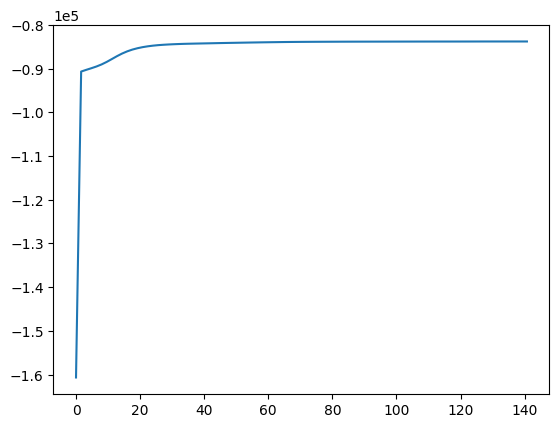

In [306]:
start = time.time()
ELBOs = []
prev_ELBO = -np.inf
curr_ELBO = compute_ELBO(LAMBDA, GAMMA, PHI, documents, nonzero_idxs, K)
ELBOs.append(curr_ELBO)
print(f"Initial ELBO: {ELBOs[0]}\n")

max_iterations = 200
tol = 10e-3
LAMBDA_t = copy.deepcopy(LAMBDA)
GAMMA_t = copy.deepcopy(GAMMA)
PHI_t = copy.deepcopy(PHI)

for t in range(max_iterations):
    print(f"Iteration {t+1}")
    for i in tqdm(range(N), desc="Updating PHI and GAMMA"):
        document = documents[i]
        nonzero_idx = nonzero_idxs[i]
        GAMMA_i_t = copy.deepcopy(GAMMA_t[i])
        word_idx = 0
        for idx in nonzero_idx:
            log_PHI_ij = np.zeros((K,))
            for k in range(K):
                LAMBDA_k_t = copy.deepcopy(LAMBDA_t[k])
                exp_propto = digamma(GAMMA_i_t[k]) - digamma(np.sum(GAMMA_i_t)) + digamma(LAMBDA_k_t[idx]) - digamma(np.sum(LAMBDA_k_t))
                log_PHI_ij[k] = exp_propto
            PHI_ij = np.exp(log_PHI_ij - log_sum_exp(log_PHI_ij))
            PHI_t[i][word_idx] = PHI_ij
            word_idx += 1
        GAMMA_i_t = np.zeros((K,)) + ALPHA
        for k in range(K):
            GAMMA_i_t[k] += np.sum(document[nonzero_idx] * PHI_t[i][:, k])
        GAMMA_t[i] = GAMMA_i_t

    for k in tqdm(range(K), desc="Updating LAMBDA"):
        LAMBDA_k_t = np.zeros((V,)) + ETA
        for i in range(N):
            document = documents[i]
            nonzero_idx = nonzero_idxs[i]
            word_idx = 0
            for idx in nonzero_idx:
                LAMBDA_k_t[idx] += document[idx] * PHI_t[i][word_idx][k]
                word_idx += 1
            LAMBDA_t[k] = LAMBDA_k_t

    prev_ELBO = curr_ELBO
    curr_ELBO = compute_ELBO(LAMBDA_t, GAMMA_t, PHI_t, documents, nonzero_idxs, K)
    ELBOs.append(curr_ELBO)
    print(f"Current ELBO: {curr_ELBO} | Change in ELBO: {curr_ELBO - prev_ELBO}\n")

    if abs(curr_ELBO - prev_ELBO) < tol:
        break
stop = time.time()

LAMBDA_final = copy.deepcopy(LAMBDA_t)
GAMMA_final = copy.deepcopy(GAMMA_t)
PHI_final = copy.deepcopy(PHI_t)

plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
plt.plot(np.linspace(0, stop-start, len(ELBOs)), ELBOs)

In [311]:
BETA

array([[3.11079641e-03, 2.02044487e-12, 1.68383310e-05, ...,
        6.99792575e-08, 4.28355125e-09, 4.84892638e-06],
       [2.36580830e-03, 4.71151982e-06, 7.91326928e-04, ...,
        1.77770180e-02, 5.35095455e-03, 1.19138825e-06],
       [7.73980813e-06, 4.85920271e-07, 8.88075744e-07, ...,
        7.40971108e-04, 3.02261699e-09, 9.24746504e-08],
       [9.90054133e-05, 2.02452363e-04, 1.49057674e-23, ...,
        2.69753831e-04, 3.55299026e-16, 8.93598745e-24],
       [4.68906722e-04, 3.14351322e-11, 1.42796402e-02, ...,
        2.53746260e-08, 5.54358950e-06, 4.52155092e-05]])

In [310]:
LAMBDA_norm = LAMBDA_final / np.sum(LAMBDA_final, axis=1, keepdims=True)
LAMBDA_norm

array([[2.37395666e-05, 2.61012355e-04, 2.37310095e-05, ...,
        2.37382354e-05, 2.39661308e-03, 2.37293082e-05],
       [5.25232886e-05, 5.25069523e-05, 5.25071293e-05, ...,
        5.25193593e-05, 5.25336005e-05, 5.24998370e-05],
       [3.21486554e-05, 3.21454466e-05, 3.21425519e-05, ...,
        3.21522940e-05, 3.21478309e-05, 3.21393135e-05],
       [3.89179261e-03, 2.76043391e-05, 9.13614180e-03, ...,
        1.18962806e-02, 2.76158982e-05, 2.76016757e-05],
       [3.89779265e-05, 3.89618748e-05, 3.89678686e-05, ...,
        3.89756908e-05, 3.89836588e-05, 3.89618730e-05]])